# Business Understanding

We will be examining data about educational outcomes in the state of North Carolina. We decided to work with education data because educational outcomes are a very strong leading predictor for economic growth. This relationship has been borne out through extensive amounts of research by academic institutions and government bodies alike. In a study published by the World Bank in 2007, “The Role of Education Quality in Economic Growth,” Eric A. Hanushek and Ludger Wößmann found that for each additional year of education a country's citizens receive, there is a 0.58% increase in long-term GDP growth. Below we can see a clear positive relationship between years of education and economic growth.

<center>
    <img src='images/yearsVsgrowth.png'>
</center>

While the number of years of education is a helpful barometer, many developed countries have roughly the same amount of compulsory education. Hanushek and Wößmann found that standardized test scores were an even better predictor of economic prosperity. In fct, they found the pattern to be persistent across low- and high-income countries.

|| |
|:---|:---|
|![alt](images/belowmeantestscores.png) | ![alt](images/abovemeantestscores.png)|

The particular dataset we will be using is from [The Belk Endowment Educational Attainment Data Repository for North Carolina Public Schools freely available on Github.com](https://github.com/jakemdrew/EducationDataNC). This data repository contains a very large amount of information on public elementary, middle, and high schools from North Carolina, United States. The speicific dataset from this repository we will be primarily working with is the 2017 public high schools "Machine Learning Dataset" as available [here](https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv). This dataset contains hundreds of datapoints about hundreds of public high schools across North Carolina. We will fully examine all variables in a later section.

Supported by Hanushek and Wößmann's findings that standardized test scores are a powerful indicator of economic prosperity, we will seek to understand the relationship between the (many) variables in the Belk dataset and SAT scores. We will bucket all schools into Low/Medium/High performing based on their average SAT score, then look to be able to predict how a school will perform, but perhaps more importantly, understand the factors that cause a school to perform well. This would allow government and non-profit agencies alike to have areas of focus when looking to provide resources to a school.

We will seek to measure the quality and usefulness of our analyses from two perspectives. First, we will track the accuracy of our classifier, that is, what percent of schools we correctly classify as Low/Medium/High performing. This will serve to validate that the relationships identified in the data are reliable. Second, we will seek a parsimonious model over a pure black-box because the ultimate value of this analysis is understanding what factors lead to higher performing schools, and redirecting capital to support those schools in need. An algorithm with 100% predictive accuracy but 0% interpretability simply identifies a school as likely to perform poorly on the SAT, which doesn't actually help the students at that school.

# Visualize Attributes

We will use the Seaborn library for visualization a handful of interesting attributes from the dataset.

In [25]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as ply

In [26]:
# Read ML datasets for 2017 public highschools directly from Github
hs_2017 = pd.read_csv("https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv")

# Filter records without an average sat score for the school
hs_2017 = hs_2017.loc[hs_2017.sat_avg_score_num > 0]

# Generate sat_avg_level and get counts
hs_2017['sat_avg_level'] = 'low'
hs_2017.loc[hs_2017.sat_avg_score_num > 900, 'sat_avg_level'] = 'medium'
hs_2017.loc[hs_2017.sat_avg_score_num > 1200, 'sat_avg_level'] = 'high'
hs_2017['sat_avg_level'].value_counts()

medium    396
low        13
high       12
Name: sat_avg_level, dtype: int64

### District Level Per Pupil Expenditures

In examing educational outcomes, a natural place to look is per pupil expenditures. One would expect that the more resources a school has a available to it, the better the average outcome of a graduate. We will examine the variable `lea_total_expense_num` which gives the average *total* expenditure per pupil at the district level. This number includes expenditures from local, state, and federal governments.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,1,'North Carolina Public High Schools, 2017')

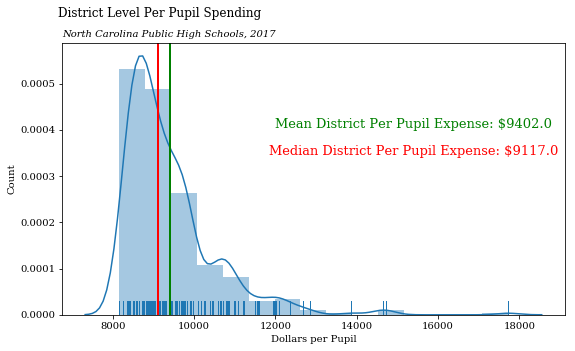

In [280]:
mu = hs_2017.lea_total_expense_num.mean()
med = hs_2017.lea_total_expense_num.median()
fig, ax = plt.subplots(figsize=(9, 5))
sns.distplot(hs_2017.lea_total_expense_num, kde=True, rug=True, bins=15)
plt.axvline(x=mu, linewidth=2, color='g')
plt.axvline(x=med, linewidth=2, color = 'r')
plt.text(.7, .7, 'Mean District Per Pupil Expense: $' + str(round(mu, 0)), 
         va='center', ha='center', transform=ax.transAxes, color='g', size=13)
plt.text(.7, .6, 'Median District Per Pupil Expense: $' + str(round(med, 0)), 
         va='center', ha='center', transform=ax.transAxes, color='r',size = 13)
plt.ylabel('Count')
plt.xlabel('Dollars per Pupil')
plt.suptitle('District Level Per Pupil Spending', x=.275)
plt.title('North Carolina Public High Schools, 2017', size=10, loc='left', style = 'italic')

In [257]:
vars = ['lea_federal_perpupil_num', 'lea_state_perpupil_num', 'lea_local_perpupil_num', 
        'lea_salary_expense_pct', 'lea_services_expense_pct', 'lea_supplies_expense_pct', 
        'lea_instruct_equip_exp_pct']

expense_pcts = hs_2017[vars].drop_duplicates()

expense_nums = expense_pcts[vars[0:3]]
expense_pcts_rat = expense_pcts[vars[3:9]]
fed_exps = expense_pcts_rat.mul(expense_nums.lea_federal_perpupil_num, axis = 0)
fed_exps['source'] = ['federal'] * fed_exps_avg.shape[0]
state_exps= expense_pcts_rat.mul(expense_nums.lea_state_perpupil_num, axis = 0)
state_exps['source'] = ['state'] * fed_exps_avg.shape[0]
local_exps = expense_pcts_rat.mul(expense_nums.lea_local_perpupil_num, axis = 0)
local_exps['source']= ['local'] * fed_exps_avg.shape[0]
all_avg_expenses = pd.concat([fed_exps, state_exps, local_exps]) \
                     .melt(id_vars = ['source']) \
                     .groupby(['source', 'variable']) \
                     .mean() \
                     .reset_index()
totals = all_avg_expenses.groupby('source').sum()
plotting = all_avg_expenses.join(totals, on = 'source',lsuffix="_caller", rsuffix="_whole")

source                    variable  value_caller  value_whole
0   federal  lea_instruct_equip_exp_pct     12.220541  1200.371491
1   federal      lea_salary_expense_pct    984.894651  1200.371491
2   federal    lea_services_expense_pct    104.246993  1200.371491
3   federal    lea_supplies_expense_pct     99.009306  1200.371491
..      ...                         ...           ...          ...
8     state  lea_instruct_equip_exp_pct     67.362494  6701.001754
9     state      lea_salary_expense_pct   5516.547524  6701.001754
10    state    lea_services_expense_pct    575.347510  6701.001754
11    state    lea_supplies_expense_pct    541.744226  6701.001754

[12 rows x 4 columns]

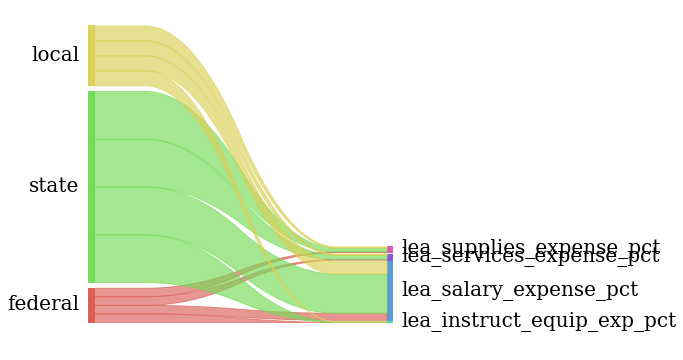

In [279]:
import sankey
#pd.options.display.max_rows=8
#%matplotlib inline
colorDict =  {'federal':'#f71b1b','state':'#1b7ef7','local':'#f3f71b'}
sankey.sankey(left=plotting['source'],
              leftLabels = ['federal', 'state', 'local'],
              leftWeight = plotting['value_whole'],
              right=plotting['variable'], 
              rightWeight=plotting['value_caller'],
              fontsize=20,
              figure_name="expenditure-split")

### Teacher Experience

Next we would like to examine teacher experience across NC schools. We will visualize the `tchyrs_0thru3_pct`, `tchyrs_4thru10_pct`, and `tchyrs_11plus_pct` variables. These variables give the percent of teachers with a given amount of experience at each individual school. Having high quality, experienced teachers is fundamental to a student being able to thrive and do well in their education. 
 

In [270]:
vars = ['tchyrs_0thru3_pct', 'tchyrs_4thru10_pct', 'tchyrs_11plus_pct']
experience = hs_2017[vars]
experience.describe()


tchyrs_0thru3_pct  tchyrs_4thru10_pct  tchyrs_11plus_pct
count         421.000000          421.000000         421.000000
mean            0.207207            0.238912           0.553888
std             0.109638            0.088699           0.118675
min             0.000000            0.000000           0.125000
25%             0.140000            0.191000           0.486000
50%             0.194000            0.234000           0.563000
75%             0.256000            0.284000           0.632000
max             0.833000            0.625000           1.000000

# Section 6: Explore Joint Attributes